# Prepare

In [113]:
# general modules
import pandas as pd
import sqlite3 
import os
import pandas_profiling
import seaborn as sns
import sqlite3 as sql
import hashlib

In [114]:
# variables
INPUT_FOLDER = "input"
OUTPUT_FOLDER = "output"
DATA_FOLDER = "data"

xl_name = "global-superstore.xls" 
db_name = "superstore.db"

randon_state = 42

# Import

In [4]:
df_orders = pd.read_excel(os.path.join("..", DATA_FOLDER, xl_name), sheet_name="Orders")
df_returns = pd.read_excel(os.path.join("..", DATA_FOLDER, xl_name), sheet_name="Returns")
df_people = pd.read_excel(os.path.join("..", DATA_FOLDER, xl_name), sheet_name="People")

### Column Inspection

In [5]:
df_orders.columns

Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority'],
      dtype='object')

In [6]:
df_returns.columns

Index(['Returned', 'Order ID', 'Market'], dtype='object')

In [7]:
df_people.columns

Index(['Person', 'Region'], dtype='object')

In [8]:
df_people

,Person,Region
0,Anna Andreadi,Central
1,Chuck Magee,South
2,Kelly Williams,East
3,Matt Collister,West
4,Deborah Brumfield,Africa
5,Larry Hughes,AMEA
6,Nicole Hansen,Canada
7,Giulietta Dortch,Caribbean
8,Nora Preis,Central Asia
9,Jack Lebron,North


In [9]:
# seems to be not relevant at all

### Integration

In [81]:
raw_df = df_orders.merge(
    df_returns[["Order ID", "Returned"]],
    on="Order ID",
    how="left",
)

In [82]:
raw_df.columns


Index(['Row ID', 'Order ID', 'Order Date', 'Ship Date', 'Ship Mode',
       'Customer ID', 'Customer Name', 'Segment', 'City', 'State', 'Country',
       'Postal Code', 'Market', 'Region', 'Product ID', 'Category',
       'Sub-Category', 'Product Name', 'Sales', 'Quantity', 'Discount',
       'Profit', 'Shipping Cost', 'Order Priority', 'Returned'],
      dtype='object')

In [83]:
# remove obviously useless columns
raw_df.drop(columns="Row ID", inplace=True)
raw_df.drop(columns="Order ID", inplace=True)

In [112]:
# anonymize customer name
raw_df["Customer Name"] = raw_df.apply(lambda x: hashlib.md5(x["Customer Name"].encode()).hexdigest(), axis=1)

# Store

In [115]:
conn = sql.connect(os.path.join("..", DATA_FOLDER, db_name))
raw_df.to_sql('superstore', conn)

C:\Users\Marc\AppData\Local\Programs\Python\Python39\lib\site-packages\pandas\core\generic.py:2779: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


 
**_--------- notebook hier aufsplitten ----------_**
 


In [2]:
# machine learning modules
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelBinarizer

import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression, Ridge, Lasso

### Train-Test-Split

In [88]:
df_train, df_test = train_test_split(raw_df, random_state = randon_state)

In [89]:
print(df_train.shape)
print(df_test.shape)

(38471, 23)
(12824, 23)


# Inspect

In [100]:
df_train.head()

,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,Country,Postal Code,...,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority,Returned
27507,2012-12-27,2012-12-31,Standard Class,SP-20860,a7d03c30d416fc5f7d695b495884fdd7,Corporate,Murfreesboro,Tennessee,United States,37130.0,...,Technology,Accessories,SanDisk Ultra 16 GB MicroSDHC Class 10 Memory ...,72.744,7,0.2,-12.7302,6.720,Medium,NaN
35511,2014-12-25,2015-01-01,Standard Class,JD-15895,1b2850c124acd1bc24237b4b5228b65e,Corporate,Oosterhout,North Brabant,Netherlands,NaN,...,Office Supplies,Labels,"Smead File Folder Labels, Adjustable",23.730,7,0.5,-21.0000,3.430,Low,NaN
9172,2012-05-08,2012-05-11,Second Class,AB-10600,6acab08bb2b385c8569adfd24730ee01,Corporate,Phnom Penh,Phnom Penh,Cambodia,NaN,...,Furniture,Bookcases,"Dania Corner Shelving, Pine",617.100,5,0.0,172.6500,36.380,Medium,NaN
31366,2011-06-30,2011-07-02,Second Class,GH-14410,1528a0a296f3ecf500753855ea9a21a5,Home Office,Lima,Lima (city),Peru,NaN,...,Furniture,Chairs,"Hon Bag Chairs, Red",54.180,3,0.4,-32.5200,4.919,Medium,Yes
24465,2013-06-23,2013-06-26,First Class,KW-16435,648a7c6f93ee0f453ee1378466a84ff8,Consumer,London,England,United Kingdom,NaN,...,Office Supplies,Storage,"Fellowes Box, Wire Frame",50.625,3,0.1,20.2050,8.570,Medium,NaN


In [101]:
df_train.columns

Index(['Order Date', 'Ship Date', 'Ship Mode', 'Customer ID', 'Customer Name',
       'Segment', 'City', 'State', 'Country', 'Postal Code', 'Market',
       'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
       'Sales', 'Quantity', 'Discount', 'Profit', 'Shipping Cost',
       'Order Priority', 'Returned'],
      dtype='object')

### Profiling

In [91]:
profile = df_train.profile_report(title='Pandas Profiling Report')

In [106]:
profile.to_file(output_file=os.path.join("..", OUTPUT_FOLDER, "data_profile.html"))

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

### Missings

In [109]:
df_train.isnull().sum()

Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       30915
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
Returned          36159
dtype: int64

Postal Code ==> useless

### Columnwise Inspection

#### Ship Date, Order Date

<AxesSubplot:xlabel='Count', ylabel='Order Date'>

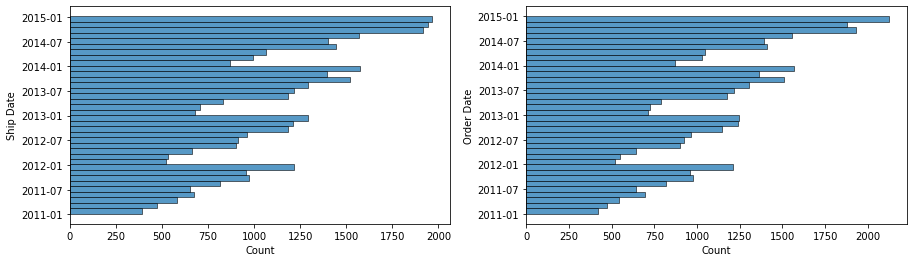

In [93]:
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [15, 4]
f, axes = plt.subplots(1, 2)

sns.histplot(data=df_train, y="Ship Date", ax=axes[0])
sns.histplot(data=df_train, y="Order Date", ax=axes[1])

* Almost the same. One column is enough.

#### Ship Mode

In [94]:
df_train["Ship Mode"].value_counts()

Standard Class    23148
Second Class       7670
First Class        5588
Same Day           2065
Name: Ship Mode, dtype: int64

* Predestined for OneHotEncoder

#### Customer ID, Customer Name

In [95]:
print("Unique values:", len(set(df_train["Customer ID"])))
print("Total values:", len(df_train["Customer ID"]))

Unique values: 1587
Total values: 38471


In [96]:
print("Unique values:", len(set(df_train["Customer Name"])))
print("Total values:", len(df_train["Customer Name"]))

Unique values: 795
Total values: 38471


=> not useless at all... classification?

#### Segment

In [97]:
df_train["Segment"].value_counts()

Consumer       20019
Corporate      11471
Home Office     6981
Name: Segment, dtype: int64

=> OneHotEncoder

#### City, State, Country

In [102]:
print("Unique values City:", len(set(df_train["City"])))
print("Unique values State:", len(set(df_train["State"])))
print("Total values:", len(df_train["State"]))

Unique values City: 3475
Unique values State: 1072
Total values: 38471


In [103]:
df_train["Country"].value_counts()

United States    7556
Australia        2137
France           2114
Mexico           2012
Germany          1570
                 ... 
Swaziland           2
South Sudan         1
Tajikistan          1
Burundi             1
Chad                1
Name: Country, Length: 147, dtype: int64

=> Too high cardinality

=> The city most likely has nothing to do with the return rate

#### Postal Code

useless due to missing values

#### Market

<AxesSubplot:ylabel='Market'>

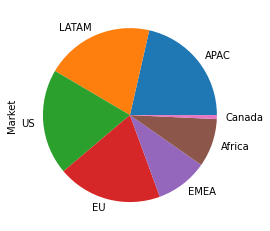

In [111]:
df_train["Market"].value_counts().plot.pie()

==> looks good, OneHotEncoder; there may be differences in the regions

In [ ]:
plt.rcParams["figure.figsize"] = [15, 4]
f, axes = plt.subplots(1, 2)

ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left') 

In [ ]:
# select potentially useful columns
useful_columns = [""]
df_inspect = df_train[useful_columns]

In [ ]:
#df_inspect.reset_index(drop=True, inplace=True)


In [ ]:
#df_inspect.loc[:,""] = LabelBinarizer().fit_transform(df_inspect["flirtInterests_date"])

In [ ]:
#sns.pairplot(data=df_inspect)

In [ ]:
#sns.heatmap(df_inspect.corr())

In [ ]:
#model = smf.ols(formula="target ~ a + b + c", data=df_inspect)
#results = model.fit()
#print(results.summary())